# Clustering Yelp Restaurants

**Part 1: To be completed INDIVIDUALLY and due on October 14 at 7pm.**

In this assignment, we will be working with the [Yelp dataset](https://drive.google.com/open?id=0B4bdB5WPHGsqcmJMNmxzQmQ3aTQ). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

From the Business Objects, let's try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" to cluster for similarity. You may want to use only a subset (15-20) of popular categories.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

In [3]:
import json
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.cluster.hierarchy import dendrogram, linkage

business_data = []
CS = 15

top_cats = ['Seafood', 'Pizza', 'American (Traditional)', 'Japanese', 'Burgers', 'Breakfast & Brunch', 'Italian', 
            'Nightlife', 'Barbeque', 'Mexican', 'Sandwiches', 'Fast Food', 'Chinese', 'Bars', 'Steakhouses', 'Cafes', 
            'Sushi Bars', 'Food', 'American (New)', 'Cluster']
    
business_df = pd.DataFrame(columns = ['Latitude', 'Longitude'] + top_cats)

with open('yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json') as business_data_file: 
    for line in business_data_file:
        d = json.loads(line)
        if d['city'] == 'Las Vegas' and 'Restaurants' in d['categories']:
            LV_dict = {'Latitude': (d['latitude'] - 36) * CS, 'Longitude': (d['longitude'] + 115) * -CS}
            for cat in top_cats:
                if cat in d['categories']:
                    LV_dict[cat] = 1
                else:
                    LV_dict[cat] = 0
            business_df = business_df.append(LV_dict, ignore_index = True)
                     
print('Loaded')

Loaded


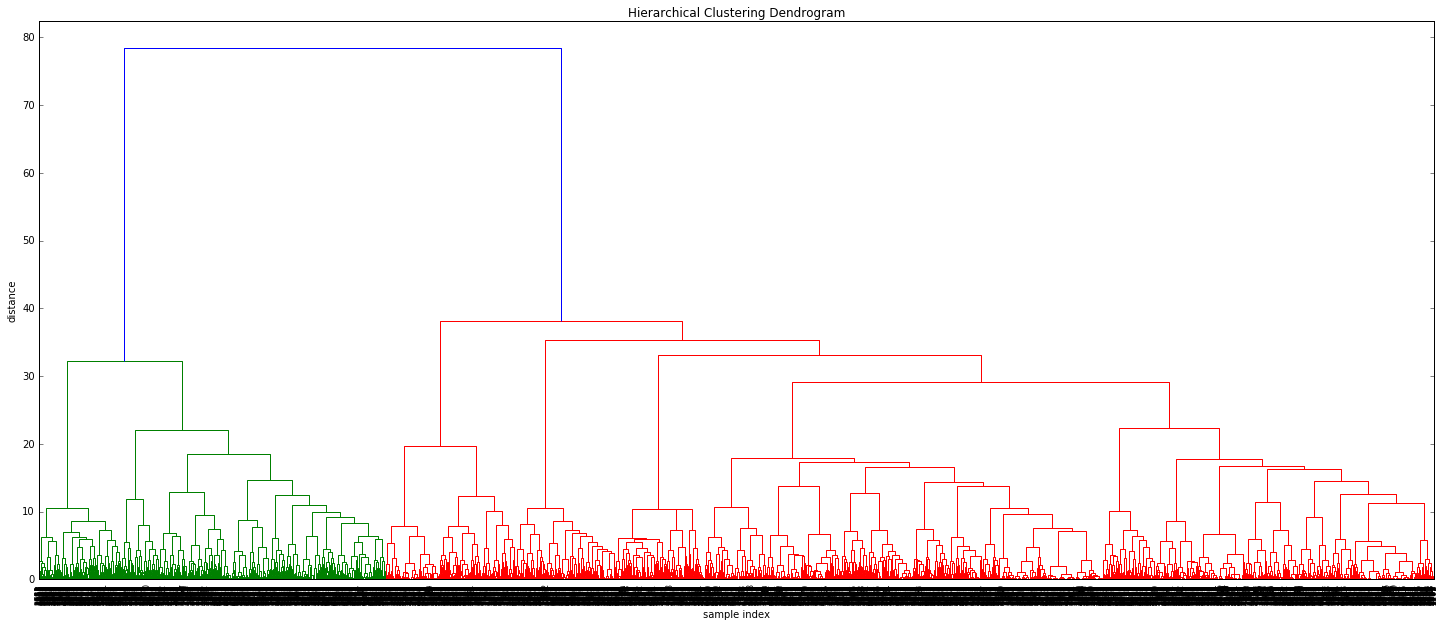

In [6]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Z = linkage(business_df, 'ward')

c, coph_dists = cophenet(Z, pdist(business_df))

%matplotlib inline

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import sklearn.metrics as metrics
import numpy as np

business_df_np = business_df.as_matrix()

def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')
    


evaluate_clusters(business_df_np, 20)

kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10).fit(business_df_np)

Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned. **(10 pts)**

Note that some categories are inherently more common (e.g. "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

In [ ]:
from math import sqrt

def euclidian_distance(x,y):
    res = 0
    for i in range(len(x)):
        res += (x[i] - y[i])**2
    return sqrt(res)

columns = ['Latitude', 'Longitude'] + top_cats

def select_cluster(x):
    m = euclidian_distance(x,kmeans.cluster_centers_[0])
    i = 0
    for c in range(1,5):
        clus = kmeans.cluster_centers_[c]
        ed = euclidian_distance(x, clus)
        if ed < m:
            m = ed
            i = c
    return i

for index, row in business_df.iterrows():
    business_df['Cluster'][index] = select_cluster(row)

centers = kmeans.cluster_centers_
cat_cluster = {top_cats[i]: [centers[j][i + 2] for j in range(5)] for i in range(len(top_cats))}


def get_top_cluster_weight(cc):
    ccc = cc[:]
    ma = max(ccc)
    mai = cc.index(ma)
    ccc.remove(ma)
    weight = 4*ma/sum(ccc)
    return [mai, weight]
    
cat_max = {cat: get_top_cluster_weight(cat_cluster[cat])  for cat in cat_cluster}                                   
top_cats_cluster = ['Mexican', 'Sushi Bars, Italian', 'Fast Food, Pizza', 'Cafes, Steakhouses',
                    'American (Traditional), Sandwiches']

pprint(cat_max)

# Scatter Plot
groups = business_df.groupby('Cluster')

fig, ax = plt.subplots()
fig.set_size_inches(11,11)

for name, group in groups:
    ax.plot(group['Latitude'], group['Longitude'], marker='o', linestyle='', ms=5, label=name)
leg = ax.legend()

texts = ['0','1','2','3','4']
for i in range(5):
    leg.get_texts()[i].set_text(texts[i])

plt.show()

for i in range(5):
    print('%s: %s' % (texts[i], top_cats_cluster[i]))
    
#End plot

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

In [ ]:
outlier_distances = [[0] * 10 for i in range(5)]
outlier_indexes = [[0] * 10 for i in range(5)]

for index, row in business_df.iterrows():
    clus_num = int(row['Cluster'].item())
    clus = centers[clus_num]
    ed = euclidian_distance(row, clus)
    m = min(outlier_distances[clus_num])
    if ed > m:
        i = outlier_distances[clus_num].index(m)
        outlier_distances[clus_num][i] = ed
        outlier_indexes[clus_num][i] = index

outlier_indexes
outliers = pd.DataFrame()
for clus in outlier_indexes:
    for out in clus:
        outliers = outliers.append(business_df.loc[out], ignore_index=True)

outliers

Give a detailed analysis comparing the results you obtained from the 3 techniques. **(10 pts)**

----------